In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import shap
import optuna
!pip install --upgrade xgboost
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [215]:
db = pd.read_excel("Retail-Supply-Chain-Sales-Dataset.xlsx")

In [216]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Row ID               9994 non-null   int64         
 1   Order ID             9994 non-null   object        
 2   Order Date           9994 non-null   datetime64[ns]
 3   Ship Date            9994 non-null   datetime64[ns]
 4   Ship Mode            9994 non-null   object        
 5   Customer ID          9994 non-null   object        
 6   Customer Name        9994 non-null   object        
 7   Segment              9994 non-null   object        
 8   Country              9994 non-null   object        
 9   City                 9994 non-null   object        
 10  State                9994 non-null   object        
 11  Postal Code          9994 non-null   int64         
 12  Region               9994 non-null   object        
 13  Retail Sales People  9994 non-nul

In [217]:
target = db.iloc[:,[4,6,7,9,11,12] + list(range(16,22))].copy()

In [218]:
target['Duration'] =db['Ship Date']-db['Order Date']
target['Ship Day'] = db['Ship Date'].dt.dayofweek
target['Ship Month']= db['Ship Date'].dt.month
target['Order Month'] = db['Order Date'].dt.month
target.sample(5)

,Ship Mode,Customer Name,Segment,City,Postal Code,Region,Sub-Category,Product Name,Returned,Sales,Quantity,Discount,Duration,Ship Day,Ship Month,Order Month
6226,Standard Class,Jeremy Farry,Consumer,Portland,97206,West,Chairs,Global Highback Leather Tilter in Burgundy,Not,291.168,4,0.2,123 days,3,9,5
1995,Second Class,Joy Smith,Consumer,Houston,77036,Central,Appliances,3.6 Cubic Foot Counter Height Office Refrigerator,Not,294.620,5,0.8,59 days,2,4,2
3619,Standard Class,Ralph Arnett,Consumer,Los Angeles,90004,West,Storage,"Trav-L-File Heavy-Duty Shuttle II, Black",Yes,217.850,5,0.0,122 days,2,8,4
6758,Standard Class,Theresa Coyne,Corporate,Lakewood,8701,East,Storage,"Contico 72""H Heavy-Duty Storage System",Not,81.960,2,0.0,4 days,1,9,9
7883,Second Class,Lena Cacioppo,Consumer,Thornton,80229,West,Paper,"Wirebound Four 2-3/4 x 5 Forms per Page, 400 S...",Not,10.320,2,0.2,92 days,0,6,3


In [219]:
target['Returned']=db['Returned'].map({'Yes':1,'Not':0})
def extract_brand(product_name):
    if isinstance(product_name,str):
        return product_name.split()[0].strip(",").title()
    return "Unknown"
target['Brand']=target['Product Name'].apply(extract_brand)
target['Duration']=target['Duration'].dt.days
target.sample(5)

,Ship Mode,Customer Name,Segment,City,Postal Code,Region,Sub-Category,Product Name,Returned,Sales,Quantity,Discount,Duration,Ship Day,Ship Month,Order Month,Brand
1239,Standard Class,Greg Matthias,Consumer,Seattle,98105,West,Art,Sanford 52201 APSCO Electric Pencil Sharpener,1,40.970,1,0.0,0,5,11,11,Sanford
1752,First Class,Victoria Wilson,Corporate,San Francisco,94122,West,Storage,"Fellowes Mobile File Cart, Black",0,559.620,9,0.0,89,4,5,2,Fellowes
298,Standard Class,Jonathan Doherty,Corporate,Belleville,7109,East,Paper,Xerox 223,0,32.400,5,0.0,0,4,10,10,Xerox
992,First Class,Roland Fjeld,Consumer,San Jose,95123,West,Fasteners,Advantus SlideClip Paper Clips,1,10.230,3,0.0,1,5,8,8,Advantus
1878,Standard Class,James Galang,Consumer,Los Angeles,90049,West,Phones,Adtran 1202752G1,0,302.376,3,0.2,34,3,2,12,Adtran


In [220]:
encoding_cols = ['Ship Mode','Segment','Sub-Category','Brand','City','Region']
for cols in encoding_cols:
    for cols in encoding_cols:
        le = LabelEncoder()
        target[cols] = le.fit_transform(target[cols])
target.drop(columns=['Product Name','Customer Name','Sales'],inplace= True)
target.sample(4)

,Ship Mode,Segment,City,Postal Code,Region,Sub-Category,Returned,Quantity,Discount,Duration,Ship Day,Ship Month,Order Month,Brand
3713,0,0,452,98103,3,9,0,3,0.0,3,0,4,4,149
6097,3,0,329,10035,1,3,1,3,0.2,6,1,9,9,334
5397,3,1,266,90004,3,1,1,12,0.0,7,6,11,11,81
9260,2,0,0,57401,0,15,0,3,0.0,3,1,11,11,25


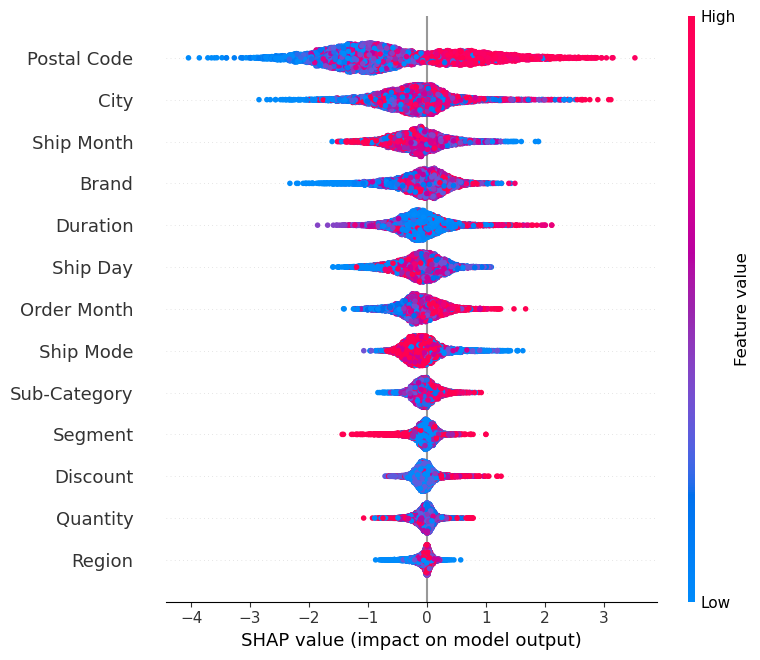

In [221]:
x1 = target.drop(columns=['Returned'])
y = target['Returned']
x_train,x_test,y_train,y_test = train_test_split(x1,y,test_size=0.2,random_state=42,stratify=y)
XGB_test=XGBClassifier(eval_metric='logloss', random_state=42)
XGB_test.fit(x_train,y_train)
explainer = shap.TreeExplainer(XGB_test)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values,x_train)

In [222]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [300,400]),
        'max_depth': trial.suggest_categorical('max_depth', [5,100]),
        'learning_rate': trial.suggest_categorical('learning_rate', [1.0,1.5]),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
        'eval_metric': 'logloss',
        'random_state': 42
    }

    model = XGBClassifier(**params)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

print("Accuracy:", study.best_value)
print("Best Parameters:", study.best_params)


[I 2025-06-23 17:47:30,984] A new study created in memory with name: no-name-dab68680-580f-49f3-8040-7222b0a2351a
[I 2025-06-23 17:47:31,296] Trial 0 finished with value: 0.9159579789894947 and parameters: {'n_estimators': 400, 'max_depth': 100, 'learning_rate': 1.5, 'subsample': 0.931524532811363, 'colsample_bytree': 0.6251958557573324, 'gamma': 1.9558707753455868, 'reg_alpha': 0.3508560345160483, 'reg_lambda': 1.1363985566067314}. Best is trial 0 with value: 0.9159579789894947.
[I 2025-06-23 17:47:31,577] Trial 1 finished with value: 0.9204602301150575 and parameters: {'n_estimators': 300, 'max_depth': 100, 'learning_rate': 1.0, 'subsample': 0.7450141185113386, 'colsample_bytree': 0.703916149412109, 'gamma': 1.828751402180075, 'reg_alpha': 3.510804227657978, 'reg_lambda': 2.0160686617869397}. Best is trial 1 with value: 0.9204602301150575.
[I 2025-06-23 17:47:32,046] Trial 2 finished with value: 0.9109554777388694 and parameters: {'n_estimators': 400, 'max_depth': 5, 'learning_rate':

Accuracy: 0.9414707353676839
Best Parameters: {'n_estimators': 400, 'max_depth': 5, 'learning_rate': 1.0, 'subsample': 0.9455290850489065, 'colsample_bytree': 0.8781207648508353, 'gamma': 0.003438373529377934, 'reg_alpha': 0.24820507325045937, 'reg_lambda': 0.36207036392799186}


In [213]:
X = target.drop(columns=['Returned','Sub-Category','Discount'])
y = target['Returned']
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 42, stratify=y)
XGB = XGBClassifier( eval_metric = 'logloss', random_state = 42)
XGB.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)